In [1]:
import os
import numpy as np
from pathlib import Path
import torch
from monai.config import print_config
from monai.data import DataLoader, CacheDataset, MetaTensor
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference

/hpc/mydata/kevin.zhao/miniconda3/envs/mlchallenge/lib/python3.9/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
def inference(model, input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(96, 96, 96),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    with torch.cuda.amp.autocast():
        return _compute(input)

## Load tomograms and picks

In [3]:
import zarr
import numpy as np
from tqdm import tqdm
import copick

copick_config_path = "/hpc/projects/group.czii/kevin.zhao/ml_challenge/example_notebooks/synthetic_data_10439.json"
root = copick.from_file(copick_config_path)

In [4]:
def get_tomogram_array(copick_run, voxel_spacing=10, tomo_type='wbp'):
    voxel_spacing_obj = copick_run.get_voxel_spacing(voxel_spacing)
    tomogram = voxel_spacing_obj.get_tomogram(tomo_type)
    image = zarr.open(tomogram.zarr(), mode='r')['0']
    return image[:]

def get_segmentation_array(copick_run, segmentation_name, voxel_spacing=10, is_multilabel=True):
    seg = copick_run.get_segmentations(is_multilabel=is_multilabel, name=segmentation_name, voxel_size=voxel_spacing)
    if len(seg) == 0:
        raise ValueError(f"No segmentations found for session '{session_id}' and segmentation type '{segmentation_type}'.")
    segmentation = zarr.open(seg[0].zarr().path, mode="r")['0']
    return segmentation[:]

### Use the rest of 20 tomograms for inference

In [5]:
test_dataset = []
for run in tqdm(root.runs[7:]):
    print(run)
    tomogram = get_tomogram_array(run)
    segmentation = get_segmentation_array(run, "paintedPicks")
    test_dataset.append({"image": tomogram, "label": segmentation})

  0%|          | 0/20 [00:00<?, ?it/s]

CopickRun(name=16176, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107760


  5%|▌         | 1/20 [00:14<04:29, 14.16s/it]

CopickRun(name=16177, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107c70


 10%|█         | 2/20 [00:21<03:03, 10.22s/it]

CopickRun(name=16178, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107340


 15%|█▌        | 3/20 [00:29<02:35,  9.15s/it]

CopickRun(name=16179, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107ac0


 20%|██        | 4/20 [00:37<02:21,  8.87s/it]

CopickRun(name=16180, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107580


 25%|██▌       | 5/20 [00:44<02:02,  8.18s/it]

CopickRun(name=16181, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107460


 30%|███       | 6/20 [00:52<01:50,  7.87s/it]

CopickRun(name=16182, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107c40


 35%|███▌      | 7/20 [00:59<01:40,  7.74s/it]

CopickRun(name=16183, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f1079d0


 40%|████      | 8/20 [01:09<01:41,  8.47s/it]

CopickRun(name=16184, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107b20


 45%|████▌     | 9/20 [01:18<01:35,  8.72s/it]

CopickRun(name=16185, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107af0


 50%|█████     | 10/20 [01:29<01:33,  9.35s/it]

CopickRun(name=16173, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107a00


 55%|█████▌    | 11/20 [01:40<01:27,  9.74s/it]

CopickRun(name=16174, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107970


 60%|██████    | 12/20 [01:57<01:35, 11.90s/it]

CopickRun(name=16175, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f1079a0


 65%|██████▌   | 13/20 [02:09<01:23, 11.91s/it]

CopickRun(name=16186, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107910


 70%|███████   | 14/20 [02:22<01:13, 12.22s/it]

CopickRun(name=16189, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f1078b0


 75%|███████▌  | 15/20 [02:36<01:04, 12.86s/it]

CopickRun(name=16190, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107850


 80%|████████  | 16/20 [02:46<00:48, 12.04s/it]

CopickRun(name=16191, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f1077f0


 85%|████████▌ | 17/20 [02:56<00:34, 11.51s/it]

CopickRun(name=16192, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107790


 90%|█████████ | 18/20 [03:12<00:25, 12.83s/it]

CopickRun(name=16187, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107730


 95%|█████████▌| 19/20 [03:23<00:12, 12.09s/it]

CopickRun(name=16188, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x14977f107670


100%|██████████| 20/20 [03:33<00:00, 10.67s/it]


### Create dataloader for the test dataset

In [8]:
from torch.utils.data import Dataset, ConcatDataset
from monai.data import DataLoader, CacheDataset, MetaTensor

test_ds = CacheDataset(data=test_dataset)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 221920.85it/s]


## Load model and weights

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(root.pickable_objects)+1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load("best_metric_model.pth", weights_only=True))
model.eval()

cuda


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Se

In [10]:
from monai.transforms import Compose, Activations, AsDiscrete
from monai.data import decollate_batch

post_pred = AsDiscrete(argmax=True)

predictions = []
with torch.no_grad():
    for data in test_loader:
        tomogram = data['image'].unsqueeze(1).to(device)  # only support batch=1 and channel first
        mask = data['label'].unsqueeze(1).to(device)
        output = inference(model, tomogram)
        predictions = [post_pred(i).squeeze(0).numpy(force=True) for i in decollate_batch(output)]

/tmp/ipykernel_2249550/3273448349.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


In [11]:
print(np.unique(predictions[0]))

[0. 1. 2. 3. 4. 5. 6. 7.]


## Visualize the inference results

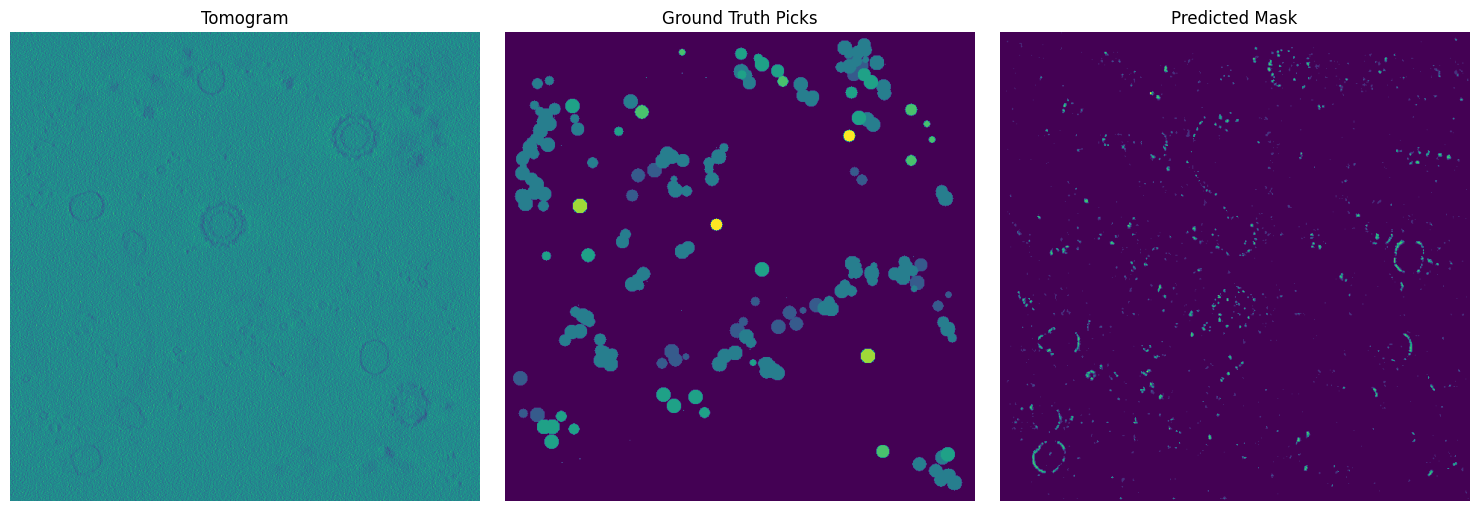

In [15]:
import matplotlib.pyplot as plt

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Tomogram')
plt.imshow(test_dataset[0]['image'][90])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ground Truth Picks')
plt.imshow(test_dataset[0]['label'][90])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(predictions[0][90])
plt.axis('off')

plt.tight_layout()
plt.show()

## Get picks from the inference masks, and save them to the copick directory

In [16]:
import copick_utils
from copick_utils.segmentation.picks_from_segmentation import picks_from_segmentation


particles = dict()
for po in root.config.pickable_objects:
    particles[po.name] = po.label

    
maxima_filter_size = 10
min_particle_size = 0
max_particle_size = 10
new_session_id = '1'
new_user_id = 'picksFromSegs'
for prediction, run in tqdm(zip(predictions, root.runs[7:])):
    for po in particles.keys():
        if po != 'membrane':
            class_label = particles[po]
            picks_from_segmentation(prediction, class_label, maxima_filter_size, min_particle_size, max_particle_size, new_session_id, new_user_id, po, run, voxel_spacing=10)